<a href="https://colab.research.google.com/github/williamsdoug/CTG_RP/blob/master/CTG_RP_Train_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Datasets and Train Model

In [1]:
! ls

basic_denoise.py     config_local.py  ctu-uhb-ctgdb  libRP.py	  sample_data
compute_metadata.py  ctg_utils.py     images	     __pycache__  test.py


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import config_local
from config_local import *

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import gc

from fastai.vision import *
from fastai.metrics import error_rate

import torch
from torch import nn


import collections
import pprint
import random

In [0]:
from compute_metadata import get_splits, generate_label_file, generate_lists

## Config

In [0]:
np.random.seed(1234)
random.seed(1234)

binary_image_stats = ([0.5]*3, [0.5]*3)

In [0]:
tfms=[]
size=64
bs=64
workers=4

path = Path() / 'images'

## Generate Train and Valid Label Files

In [0]:
train_valid_groups_full = get_splits(image_dir='images', image_file='rp_images_index.json', 
                                     exclude=['_clipped'],
                                     thresh = 7.15)
              
# Create valid_x.csv files for each split
for i in range(len(train_valid_groups_full)):
    generate_lists(train_valid_groups_full[i], train_file='train_{}.csv'.format(i),
                   valid_file='valid_{}.csv'.format(i))

In [9]:
!ls images/*.csv

images/train_0.csv  images/train_3.csv	images/valid_1.csv  images/valid_4.csv
images/train_1.csv  images/train_4.csv	images/valid_2.csv
images/train_2.csv  images/valid_0.csv	images/valid_3.csv


In [0]:
train = ImageList.from_csv(path, 'train_0.csv')
valid = ImageList.from_csv(path, 'valid_0.csv')

lls = ItemLists(path, train, valid).label_from_df(cols=1).transform(tfms, size=size) 
#db = lls.databunch(bs=bs, num_workers=workers)#.normalize(binary_image_stats)
db = lls.databunch(bs=bs, num_workers=workers)
my_stats = db.batch_stats()
db = lls.databunch(bs=bs, num_workers=workers).normalize(my_stats)

In [11]:
db.batch_stats()

[tensor([0.0789, 0.0789, 0.0789]), tensor([1.1388, 1.1388, 1.1388])]

### Examine Results

In [12]:
print('nClass: {}    classes: {}'.format(db.c, db.classes))
db

nClass: 2    classes: [0, 1]


ImageDataBunch;

Train: LabelList (492 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: images;

Valid: LabelList (120 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: images;

Test: None

492 torch.Size([599, 599])


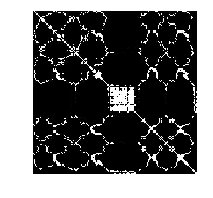

In [13]:
im = train.get(-1)
print(len(train), im.size)
im.show()

## Model

In [0]:
trial_model = nn.Sequential(
    nn.Sequential(
          nn.Conv2d(3,8,5),     # 60 × 60 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 29 × 29 × 8
        
          #nn.Dropout(p=0.25),
          nn.Conv2d(8,8,5),         # 25 × 25 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 12 × 12 × 8
        
          Flatten()         # 1152
    ),
    # removed model head to compute flatten size
)

In [15]:
trial_learn = Learner(db, trial_model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
trial_learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 60, 60]          608        True      
______________________________________________________________________
ReLU                 [8, 60, 60]          0          False     
______________________________________________________________________
AvgPool2d            [8, 29, 29]          0          False     
______________________________________________________________________
Conv2d               [8, 25, 25]          1,608      True      
______________________________________________________________________
ReLU                 [8, 25, 25]          0          False     
______________________________________________________________________
AvgPool2d            [8, 12, 12]          0          False     
______________________________________________________________________
Flatten              [1152]               0          False     
______________________________________________________________

In [16]:
del trial_model
trial_learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [0]:
mymodel = nn.Sequential(
    nn.Sequential(
          nn.Conv2d(3,8,5),     # 60 × 60 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 29 × 29 × 8
        
          #nn.Dropout(p=0.25),
          nn.Conv2d(8,8,5),         # 25 × 25 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 12 × 12 × 8
        
          Flatten()         # 1152
    ),
    nn.Sequential(
#           nn.Dropout(p=0.25),
          nn.Linear(1152, 144),
          nn.ReLU(),
          nn.Dropout(p=0.8),
          nn.Linear(144, db.c) 
    )
)

In [0]:
learn = Learner(db, mymodel, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.summary()
learn.save('initial')

# Train Model

In [19]:
learn.fit_one_cycle(1, 1e-6)  # learn.fit_one_cycle(1, 0.01)

# learn.save('save-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.692552,0.693021,0.525000,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


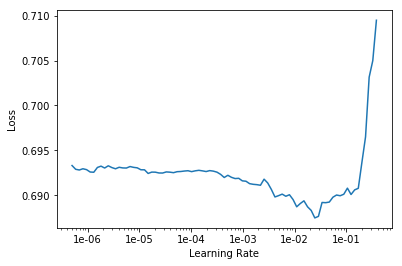

In [20]:
learn.lr_find(end_lr=1)
learn.recorder.plot()

In [21]:
learn.load('initial')
learn.fit_one_cycle(100, 3e-3)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.692939,0.693003,0.533333,00:03
1,0.693173,0.693340,0.466667,00:04
2,0.692604,0.693599,0.483333,00:04
3,0.691220,0.693523,0.466667,00:04
4,0.690516,0.693568,0.508333,00:04
5,0.689290,0.693320,0.500000,00:04
6,0.690177,0.693475,0.466667,00:04
7,0.686589,0.694530,0.516667,00:04
8,0.683592,0.699543,0.541667,00:03
9,0.681860,0.694420,0.533333,00:04


In [22]:
learn.load('initial')
learn.fit_one_cycle(100, 1e-2)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.692227,0.693304,0.466667,00:04
1,0.691602,0.693173,0.483333,00:04
2,0.689633,0.692785,0.533333,00:04
3,0.689727,0.692887,0.500000,00:04
4,0.689559,0.690822,0.508333,00:04
5,0.686462,0.690333,0.500000,00:03
6,0.685391,0.696042,0.508333,00:04
7,0.681146,0.691425,0.533333,00:04
8,0.678514,0.688418,0.550000,00:04
9,0.673973,0.682059,0.558333,00:03


In [23]:
learn.load('initial')
learn.fit_one_cycle(100, 1e-3)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.693725,0.693106,0.541667,00:04
1,0.694120,0.693053,0.541667,00:04
2,0.693665,0.693024,0.525000,00:04
3,0.693396,0.692995,0.516667,00:04
4,0.692961,0.692862,0.500000,00:04
5,0.692419,0.692717,0.516667,00:04
6,0.691409,0.692630,0.491667,00:03
7,0.691121,0.692595,0.483333,00:04
8,0.690768,0.692339,0.533333,00:04
9,0.690312,0.692919,0.550000,00:04
